# In which I help you decide if cash4u@freestuff.net is legit or not.

Week 7 of Andrew Ng's ML course on Coursera introduces the Support Vector Machine algorithm and challenges us to use it for classifying email as spam or ham. Here I use the [SpamAssassin public corpus](https://spamassassin.apache.org/publiccorpus/) to build an SVM spam email classifier in order to learn about the relevant python tools. [Part I](http://sdsawtelle.github.io/blog/output/spam-classification-text-processing.html) focused on the preprocessing of individual emails, but now I'm going to actually do some machine learning. 

>## Tools Covered:
- `CountVectorizer` for mapping text data to numeric word occurrence vectors
- `tfidfTransformer` for normalizing word occurrence vectors 
- `Pipeline` for chaining together transformer (preprocessing, feature extraction) and estimator steps
- `GridSearchCV` for optimizing over the metaparameters of an estimator or pipeline

In [1]:
# Set up environment
import scipy.io
import matplotlib.pyplot as plt
import matplotlib 
import pandas as pd
import numpy as np
import pickle
import os
import re

from nltk.stem.snowball import SnowballStemmer
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

import snips as snp  # my snippets
snp.prettyplot(matplotlib)  # my aesthetic preferences for plotting
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sonya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
cd hw-wk7-spam-svm

C:\Users\Sonya\Box Sync\Projects\course-machine-learning\hw-wk7-spam-svm


# Quick Look at the Data
In [Part I](http://sdsawtelle.github.io/blog/output/spam-classification-text-processing.html) of this post I created a corpus of raw email bodies, and fully processed email bodies, together with the vector of ground truth for these emails ($y=0$ for ham). The processed emails have had all stop words removed and all words stemmed to their root. 

I'll first read in these pickled objects and give a quick preview of them:

In [3]:
with open("easyham_and_spam_corpus_raw_and_processed_and_y.pickle", "rb") as myfile:
    emails_raw, emails_processed, y = pickle.load(myfile)

In [4]:
emails_raw[0]

'\n    Date:        Wed, 21 Aug 2002 10:54:46 -0500\n    From:        Chris Garrigues <cwg-dated-1030377287.06fa6d@DeepEddy.Com>\n    Message-ID:  <1029945287.4797.TMDA@deepeddy.vircio.com>\n\n\n  | I can\'t reproduce this error.\n\nFor me it is very repeatable... (like every time, without fail).\n\nThis is the debug log of the pick happening ...\n\n18:19:03 Pick_It {exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace} {4852-4852 -sequence mercury}\n18:19:03 exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace 4852-4852 -sequence mercury\n18:19:04 Ftoc_PickMsgs {{1 hit}}\n18:19:04 Marking 1 hits\n18:19:04 tkerror: syntax error in expression "int ...\n\nNote, if I run the pick command by hand ...\n\ndelta$ pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace  4852-4852 -sequence mercury\n1 hit\n\nThat\'s where the "1 hit" comes from (obviously).  The version of nmh I\'m\nusing is ...\n\ndelta$ pick -version\npick -- nmh-1.0.4 [compiled on fuchsia

In [23]:
emails_processed[0]

'date wed aug chris garrigu messag id cant reproduc error repeat like everi time without fail debug log pick happen pick exec pick inbox list lbrace lbrace subject ftp rbrace rbrace sequenc mercuri exec pick inbox list lbrace lbrace subject ftp rbrace rbrace sequenc mercuri ftoc pickmsg hit mark hit tkerror syntax error express int note run pick command hand delta pick inbox list lbrace lbrace subject ftp rbrace rbrace sequenc mercuri hit that hit come obvious version nmh im use delta pick version pick nmh compil fuchsia cs mu oz au sun mar ict relev part mh profil delta mhparam pick seq sel list sinc pick command work sequenc actual one that explicit command line search popup one come mh profil get creat kre ps still use version code form day ago havent abl reach cvs repositori today local rout issu think exmh worker mail list'

# Mapping Text to Vectors
Any classification algorithm we might want to use for this task is going to expect numeric input features, so we can't just feed it our email strings. Instead we'll map each email to a vector whose elements reflect the presence of specific words in that email. For instance, we could map to a vector $x$ where $x_1 = $ (# of times the word 'money' appears), $x_2 = $ (# of times the word 'stop' appears) etc. This mapping constitutes a "Bag of Words" approach because no information about the relative position of words in the email is retained. The words that we count to construct the elements of this vector constitute our **Vocab List**, in the above our vocab list would be ['money', 'stop']. **Each vocab word leads to a feature that reflects the presence of that word in an email.**

These numeric vectors can reflect either the binary presence of the words or the number of occurrences of the words. Let me quote directly from a [wonderful sklearn tutorial](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html) on the topic of occurrence count features:

> Occurrence count is a good start but there is an issue: longer documents will have higher average count values than shorter documents, even though they might talk about the same topics.
To avoid these potential discrepancies it suffices to divide the number of occurrences of each word in a document by the total number of words in the document: these new features are called tf for **"Term Frequencies"**
Another refinement on top of tf is to downscale weights for words that occur in many documents in the corpus and are therefore less informative than those that occur only in a smaller portion of the corpus.
This downscaling is called **tf–idf for “Term Frequency times Inverse Document Frequency”**

The sklearn docs also have [more info on tf-idf](http://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting) in the User Guide.

# Creating a "Vocab List" of Selected Words
If we make a list of all the words from all the emails then it will have a very large number of unique elements, but some of those words don't appear very often and thus won't be very useful for us. Instead its common to make your Vocab List from only the significantly common words. Let's explore what our vocab list might look like:

In [6]:
flatlist = [word for email in emails_processed for word in email.split(" ")]  # A flat list of all words from all emails

In [7]:
# Count number of appearances of each word and store as dictionary
import collections
counts_dict = collections.Counter(flatlist)

I want to get a sense of the distribution over word-frequencies. The word "number" is going to be vastly more common than any other word and definitely any word that only appears once or twice in the whole email corpus is not going to help us much, so we'll ignore those:

(50, 1000)

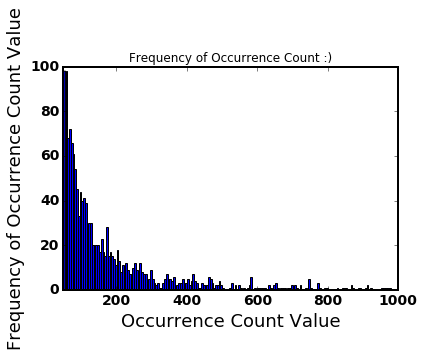

In [9]:
fig, ax = plt.subplots(figsize=[6, 4])
snp.labs("Occurrence Count Value", "Frequency of Occurrence Count Value", "Frequency of Occurrence Count :)")
plt.hist([num for num in counts_dict.values() if num > 50 and num < 12000], bins=1000)
plt.xlim([50, 1000])

Lets get a sense of what our vocab list would be like if we only used words who appeared a hundred or more times:

In [8]:
vocablist = [key for key in counts_dict if counts_dict[key] > 100]
len(vocablist)

877

In [10]:
vocablist[10:17]

['billion', 'ad', 'togeth', 'propos', 'generat', 'stuff', 'edit']

This criteria of demanding a frequency of at least 100 appearances would give us a vocab list of 865 words to use to define our feature space.

# Vectorizing the Emails
**Given the corpus of processed emails and Vocab List of selected words, we want to map each email to a numeric vector that reflects the occurrence (or frequency) of different vocab words.** The tool in sklearn that helps us do this is `CountVectorizer`. It is a class that tokenizes input text and converts it into a numeric vector. Let's do an example using the vocab list we generated above and assuming we want our vectors to reflect actual word count, rather than binary presence of the word (if you want binary, then specify kwarg `binary=True`):

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

In [11]:
# Specify our vocab list, and use processed email bodies
vectorizer = CountVectorizer(vocabulary=vocablist)  
X = vectorizer.transform(emails_processed)
X 

<3046x877 sparse matrix of type '<class 'numpy.int64'>'
	with 150787 stored elements in Compressed Sparse Row format>

In [22]:
X[30, 30] # The number of times the 30th word appears in the 30th email

3

## Using a Custom Preprocessing Function
Left to its own devices `CountVectorizer` will intelligently tokenize your email to extract individual words to the best of its ability. For more control you can pass it your own preprocessing function which should take in a document (raw email body in this case) and return a processed one. The function we defined in [Part I](http://sdsawtelle.github.io/blog/output/spam-classification-text-processing.html), `word_salad()` is exactly this kind of preprocessor, and so we could feed our raw email body strings to `CountVectorizer` instead of our processed ones.

In [5]:
def word_salad(body):
    '''Produce a word salad from email body.'''    
    # Parse HTML extract content only (but count tags)
    soup = BeautifulSoup(body, 'html.parser')
    body = soup.get_text()
    
    # Pull out only the non-markup tex
    body = soup.get_text()

    # Count the number of HTML elements and specific link elements
    nhtml = len(soup.find_all())
    nlinks = len(soup.find_all("a"))
    # Sub in special strings for "counting"
    body = body + nhtml*" htmltag " + nlinks*" linktag "
    
    # lowercase everything
    body = body.lower()
    
    # Replace all URLs with special strings
    regx = re.compile(r"(http|https)://[^\s]*")
    body, nhttps = regx.subn(repl=" httpaddr ", string=body)

    # Replace all email addresses with special strings
    regx = re.compile(r"\b[^\s]+@[^\s]+[.][^\s]+\b")
    body, nemails = regx.subn(repl=" emailaddr ", string=body)
    
    # Replace all numbers with special strings
    regx = re.compile(r"\b[\d.]+\b")
    body = regx.sub(repl=" number ", string=body)

    # Replace all $, ! and ? with special strings
    regx = re.compile(r"[$]")
    body = regx.sub(repl=" dollar ", string=body)
    regx = re.compile(r"[!]")
    body = regx.sub(repl=" exclammark ", string=body)
    regx = re.compile(r"[?]")
    body = regx.sub(repl=" questmark ", string=body)

    # Remove all other punctuation (replace with white space)
    regx = re.compile(r"([^\w\s]+)|([_-]+)")  
    body = regx.sub(repl=" ", string=body)
    
    # Replace all newlines and blanklines with special strings
    regx = re.compile(r"\n")
    body = regx.sub(repl=" newline ", string=body)
    regx = re.compile(r"\n\n")
    body = regx.sub(repl=" blankline ", string=body)

    # Make all white space a single space
    regx = re.compile(r"\s+")
    body = regx.sub(repl=" ", string=body)

    # Remove any trailing or leading white space
    body = body.strip(" ")
 
    # Remove all useless stopwords
    bodywords = body.split(" ")
    keepwords = [word for word in bodywords if word not in stopwords.words('english')]

    # Stem all words
    stemmer = SnowballStemmer("english")
    stemwords = [stemmer.stem(wd) for wd in keepwords]
    body = " ".join(stemwords)

    return body

In [24]:
# Specify our custom preprocessor and use raw email bodies
vectorizer = CountVectorizer(preprocessor=word_salad, vocabulary=vocablist)
X = vectorizer.transform(emails_raw)
X 

<3046x877 sparse matrix of type '<class 'numpy.int64'>'
	with 150787 stored elements in Compressed Sparse Row format>

## Automatic Vocab List Generation
`CountVectorizer` is capable of creating a vocab list for you automatically, based on the criterion of *document* frequency (the number or proportion of documents that a word appears in). You can set the max and min frequency or proportion using kwargs `min_df` and `max_df` (a float is interpreted as proportion of documents). To create the vocab list you must first `fit` the vectorizer with your corpus, then it can be used to `transform` the corpus.

In [156]:
# Let vectorizer automatically build a vocab list
vectorizer = CountVectorizer(min_df=0.03, max_df=1.0)  
vectorizer.fit(emails_processed)

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8',
        input=['date wed aug chris garrigu messag id cant reproduc error repeat like everi time without fail debug log pick happen pick exec pick inbox list lbrace lbrace subject ftp rbrace rbrace sequenc mercuri exec pick inbox list lbrace lbrace subject ftp rbrace rbrace sequenc mercuri ftoc pickmsg hit m...umber conveni time return call certain happi remov address list click follow link send blank email'],
        lowercase=True, max_df=1.0, max_features=None, min_df=0.03,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

The `vectorizer` object now has a vocab list attribut that can be accessed in various ways. 

In [41]:
vectorizer.get_feature_names()[10:17]

['address', 'ago', 'agre', 'allow', 'almost', 'along', 'alreadi']

In [42]:
len(vectorizer.get_feature_names())

591

## Looking at Chunks of More than One Word (n-grams)
With `CountVectorizer` we have to option to include not just individual words in our vocab list but also groups of $n$ contiguous words (n-grams)? This would take us beyond the "bag of words" model because now the position of words in an email matters. The `ngram_range` kwarg takes a tuple that specifies the smallest group size and largest group size that will be considered.

In [92]:
vectorizer = CountVectorizer(min_df=0.03, max_df=1.0, ngram_range=(1, 2)) 
vectorizer.fit(emails_processed)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8',
        input=['date wed aug chris garrigu messag id cant reproduc error repeat like everi time without fail debug log pick happen pick exec pick inbox list lbrace lbrace subject ftp rbrace rbrace sequenc mercuri exec pick inbox list lbrace lbrace subject ftp rbrace rbrace sequenc mercuri ftoc pickmsg hit m...umber conveni time return call certain happi remov address list click follow link send blank email'],
        lowercase=True, max_df=1.0, max_features=None, min_df=0.03,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

Having specified a maximum n-gram size of two, we should now see single words and word pairs in our fitted vocab list:

In [93]:
vectorizer.get_feature_names()[143:150]

['either', 'els', 'email', 'email sponsor', 'encod', 'end', 'end pgp']

# Tranforming Count Occurrence Vectors to TF or TF-IDF
As we said, occurrence count for a word has a lot of drawbacks, but it can be turned into a more robust feature with `TfidTransformer`. You can ask this tool for just the term-frequencies, or the "Term Frequency times Inverse Document Frequency” (tf-idf). It expects to be passed a matrix of occurrence counts, like that which you get from `CountVectorizer`, and it will return your the tf or tf-idf transformed matrix of frequencies. 

In [6]:
from sklearn.feature_extraction.text import TfidfTransformer

In [25]:
tf_transformer = TfidfTransformer(use_idf=False).fit(X)
X_tf = tf_transformer.transform(X)

X_tf[30, 30]  # term frequency of 30th vocab word in the 30th email

0.080669648511006734

In [27]:
tfidf_transformer = TfidfTransformer(use_idf=True).fit(X)
X_tfidf = tfidf_transformer.transform(X)

X_tfidf[30, 30]  # term freqn - inverse doc freqn of 30th vocab word in the 30th email

0.29097091996720964

# Optimizing Over Preprocessers with `Pipeline` and `GridSearchCV`
Clearly some uncertainty still remains in what is the best way to proceed with vectorization:

- What words should be included in this vocab list?
- Should the numeric feature be binary occurrence, tf, or tf-idf?
- Should we use only words in our vocab list, or also include groups of $n$ contiguous words (n-grams)?

All of the above questions have to do with *preprocessing* of the data into the numeric vectors rather than with the SVM algorithm itself. To compare the performance of an algorithm under different preprocessing options in sklearn we can use a `Pipeline`: a chain of sklearn objects which transforms (or fits) your data sequentially. Once the pipeline is created, `GridSearchCV` can be used to vary parameters of any step in the pipeline. 

A pipeline has its own `fit` method that results in the full sequence of transformations being executed ending with a fit of the final estimator in the pipeline. I'll be using a support vector machine as my final estimator, you can take a look at another of my posts if you want to learn more about [SVMs and Grid Search in python](http://sdsawtelle.github.io/blog/output/week7-andrew-ng-machine-learning-with-python.html).

In [7]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

You initialize a pipeline by providing it with every object in the pipeline, each of which you give a nickname to:

In [8]:
# Define component objects of our pipeline then create it!
objs = [("vect", CountVectorizer()), 
        ("tfidf", TfidfTransformer()),
        ("svm", SVC(kernel="rbf"))]
pipe = Pipeline(objs)
pipe.named_steps

{'svm': SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
   max_iter=-1, probability=False, random_state=None, shrinking=True,
   tol=0.001, verbose=False),
 'tfidf': TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True),
 'vect': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=1.0, max_features=None, min_df=1,
         ngram_range=(1, 1), preprocessor=None, stop_words=None,
         strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
         tokenizer=None, vocabulary=None)}

To conduct the grid search on the parameter space we'll need to pass `GridSearchCV` the pipeline we just created, as well as a specification of what parameters of the different objects we will be varying, and over what range. Within the vectorizer we will try different minimum frequencies as our vocab list cutoff and n-grams of different sizes. Within the tf-idf transformer we'll try including vs. not including inverse document frequency. Within the SVM we will want to optimize over the inverse regularization, C, as well as the spread parameter of the guassian kernel, gamma. 

First I'll try a smaller subset of these parameter values, to avoid running a long computation. To refer to a specific parameters of a specific step in the pipeline you use `<estimator nickname>__<parameter>` syntax:

In [13]:
# Specify parameters of the pipeline and their ranges for grid search
params = {
    'vect__min_df': np.linspace(0.005, 0.05, 5),
    'vect__ngram_range': ((1, 1),(1, 2)),  # unigrams or bigrams
    'tfidf__use_idf': (True, False),
    'svm__C': np.logspace(-1, 2, 10),
    'svm__gamma': np.logspace(-1, 1, 10),
}

# Construct our grid search object
search = GridSearchCV(pipe, param_grid=params)

The grid search object is induced to actually perform the search by the `fit` method, the results can then be inspected. When running the algorithm at each point in your parameter space grid this guy will do 3-fold cross-validation (you can change the fold number with kwarg `cv`).

In [14]:
search.fit(emails_processed, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'vect__min_df': array([ 0.005  ,  0.01625,  0.0275 ,  0.03875,  0.05   ]), 'vect__ngram_range': ((1, 1), (1, 2)), 'svm__gamma': array([  0.1    ,   0.16681,   0.27826,   0.46416,   0.77426,   1.29155,
         2.15443,   3.59381,   5.99484,  10.     ]), 'tfidf__use_idf': (True, False), 'svm__C': array([   0.1    ,    0.21544,    0.46416,    1.     ,    2.15443,
          4.64159,   10.     ,   21.54435,   46.41589,  100.     ])},
       pre_dispatch='2*n_jobs'

In [15]:
print("Best parameter values:")
for param in search.best_params_.items():
    print(param)

Best parameter values:
('vect__min_df', 0.0050000000000000001)
('vect__ngram_range', (1, 2))
('svm__gamma', 2.1544346900318834)
('tfidf__use_idf', False)
('svm__C', 2.1544346900318834)


In [16]:
print("CV Score using best parameter values:", search.best_score_)

CV Score using best parameter values: 0.983585029547


The scoring metric here is the default scoring method for the final estimator: in this case it's classification accuracy. We're doing pretty well, at 98% of emails correctly classified. It seems that using a large number of vocab words (`min_df=0.02`) and using the idf weighting (`use_idf=True`) gave us the best performance. 